In [55]:
import numpy as np
from dtw import dtw
from numpy.core.shape_base import block
from scipy import signal
from scipy.signal.windows import hann
from scipy.fft import fft
from scipy import stats
import evaluate
import math
from scipy.io.wavfile import read as wavread
from matplotlib import pyplot as plt

In [26]:
test_path = 'letters/1/A/PZ/0.wav'

In [27]:
fs, x = wavread(test_path)

In [66]:
def  block_audio(x,fs, blockSize=2048,hopSize=512):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])

    x = np.concatenate((x, np.zeros(blockSize)),axis=0)

    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])

        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return xb

def ToolReadAudio(cAudioFilePath):
    [samplerate, x] = wavread(cAudioFilePath)
    if x.dtype == 'float32':
        audio = x
    else:
        # change range to [-1,1)
        if x.dtype == 'uint8':
            nbits = 8
        elif x.dtype == 'int16':
            nbits = 16
        elif x.dtype == 'int32':
            nbits = 32
        audio = x / float(2**(nbits - 1))

    # special case of unsigned format
    if x.dtype == 'uint8':
        audio = audio - 1.
    return (samplerate, audio)

def compute_spectrogram(xb, fs):
    window = signal.hann(xb.shape[1])
    windowed_signal = xb*window
    X_jw = fft(windowed_signal)
    X = abs(X_jw)
    f = np.arange(X.shape[1])*fs/X.shape[1]
    bins = f.size // 2 + 1 
    return X[:,:bins]

In [67]:
def get_power(x):
    # return np.log10((block_audio(np.diff(x), 2048, 512)**2).sum(axis=1).clip(1e-10, 1)) * 10
    xb = block_audio(np.diff(x), 2048, 512)
    # xb *= np.hanning(xb.shape[1])[None, :]
    return np.log10(np.maximum((xb**2).sum(axis=1), 1e-10)) * 10
    # spec = np.abs(np.fft.rfft(xb))[:, :22]
    # return (spec**2).sum(axis=1)
    # return np.log10((spec**2).sum(axis=1).clip(1e-10, 1)) * 10

In [68]:
def get_spectral_flux(x, fs, blockSize, hopSize):
    xb = block_audio(x, fs, blockSize, hopSize)
    spec_diff = (np.diff(compute_spectrogram(xb, fs), axis = 0))**2
    flux = np.sqrt(np.sum(spec_diff, axis = 1))/spec_diff.shape[1]
    plt.plot(flux)
    return flux

In [69]:
def extract_spectral_flux(xb):
    X = fft(hann(xb.shape[1])*xb)
    bins = X.shape[1] // 2
    mag = np.abs(X)[:,:bins]
    diff = np.concatenate((np.zeros((1,mag.shape[1])), mag[:-1]), axis=0)
    spectral_flux = np.sqrt(np.sum(np.square(mag-diff), axis=1))/(mag.shape[1]+1)
    return spectral_flux

ValueError: operands could not be broadcast together with shapes (125,) (124,) 

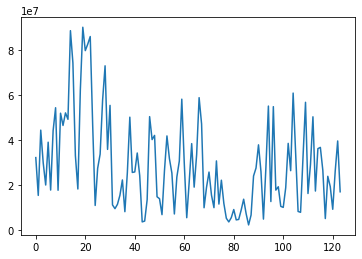

In [73]:
xb = block_audio(x, fs, 2048, 512)
extract_spectral_flux(xb) get_spectral_flux(x, fs, 2048, 512)